# Implementing a Convolutional Neural Network (CNN) for MNIST (Chapter 14)

---

This notebook provides the first complete, working implementation of a **Convolutional Neural Network (CNN)**, applying it to the **MNIST handwritten digit classification** problem. It combines the data handling fundamentals (Chapter 12) and the training mechanics (Chapter 13) with the image-specific layers introduced in **Chapter 14: Classifying Images with Deep CNNs**.

## 1. The CNN Architecture: `Conv2d`, `MaxPool2d`, and Flattening 🧱

The core of this notebook is the custom model class which defines the multi-stage CNN architecture:

* **Convolutional Layers (`nn.Conv2d`):** These are the feature extractors. The model defines several convolutional layers that apply learned filters (kernels) across the input image to automatically discover features (edges, corners, etc.) and generate **feature maps**.
* **Activation:** The output of each convolutional layer is passed through a non-linear activation function, typically **`nn.ReLU()`**.
* **Pooling Layers (`nn.MaxPool2d`):** These layers are used after convolution to progressively reduce the spatial size (height and width) of the feature maps. This reduces the number of parameters and computation, and makes the features more robust to slight shifts or distortions in the input image. 
* **Flattening:** After the final convolution and pooling stages, the 3D feature maps are **flattened** into a 1D vector. This step prepares the data to be fed into the final fully connected layers.
* **Fully Connected Layers (`nn.Linear`):** The flattened vector is passed through one or more fully connected layers, which perform the final classification based on the extracted features. The final layer has **10 output units** for the 10 digit classes.

## 2. Optimized Data Pipeline for CNNs

* **Data Preparation:** The **`torchvision.datasets.MNIST`** dataset is loaded, ensuring that the images are correctly transformed into PyTorch Tensors (Channel, Height, Width) format, suitable for the `nn.Conv2d` layer.
* **Data Loaders:** A **`DataLoader`** is set up to stream batches of images during training, allowing the large feature maps generated by the CNN to be processed efficiently.

## 3. Training and Visualization

* **Loss Function:** **`nn.CrossEntropyLoss`** is used, providing numerically stable loss calculation for the multiclass problem.
* **Training Loop:** A standard PyTorch training loop is executed, applying the optimizer (`optim.Adam` or `optim.SGD`) to update the weights based on the calculated gradients.
* **Visual Confirmation:** The notebook includes a powerful visualization section:
    * It takes samples from the test set.
    * It runs each image through the trained CNN model.
    * It displays the original image alongside the model's final **predicted digit**, visually confirming the CNN's ability to classify handwritten digits.

This notebook is the practical entry point into modern deep learning, demonstrating the immense power of combining convolutional layers with standard network architecture.

In [32]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch import nn, optim
from torch.utils.data import Subset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [41]:
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

In [42]:
mnist_all = MNIST(root= image_path, 
                  train= True,
                  download= False, 
                  transform= transform)

In [43]:
mnist_train = Subset(mnist_all, torch.arange(10000))
mnist_valid = Subset(mnist_all, torch.arange(10000, len(mnist_all)))
mnist_test = MNIST(root= image_path,
                   train= False, 
                   download= False,
                   transform= transform)

In [44]:
batch_size = 64
torch.manual_seed(28)
train_dl = DataLoader(mnist_train, batch_size, shuffle= True)
val_dl = DataLoader(mnist_valid, batch_size, shuffle= True)

In [50]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= 5, padding= 2)
)
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('relu1', nn.ReLU())
model.add_module(
    'conv2',
    nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 5, padding= 2)
)
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('relu2', nn.ReLU())
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p= 0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [52]:
def train(model, train_dl, val_dl, num_epochs= 20):
    loss_train_hist = [0] * num_epochs
    loss_val_hist = [0] * num_epochs
    acc_train_hist = [0] * num_epochs
    acc_val_hist = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train_hist[epoch] += loss.item() * y_batch.size(0)
            is_correct = (
                torch.argmax(pred, dim= 1) == y_batch
            ).float()
            acc_train_hist[epoch] += is_correct.sum()
        loss_train_hist[epoch] /= len(train_dl.dataset)
        acc_train_hist[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_val_hist[epoch] += loss.item() * y_batch.size(0)
                is_correct = (
                    torch.argmax(pred, dim= 1) == y_batch
                ).float()
                acc_val_hist[epoch] += is_correct.sum()
            loss_val_hist[epoch] /= len(val_dl.dataset)
            acc_val_hist[epoch] /= len(val_dl.dataset)
            
        print(f'Epoch {epoch+1} Accuracy: '
              f'{acc_train_hist[epoch]:.4f} Validation Accuracy: '
              f'{acc_val_hist[epoch]:.4f}')
    return loss_train_hist, loss_val_hist, acc_train_hist, acc_val_hist, hist

In [53]:
torch.manual_seed(1)
hist = train(model, train_dl, val_dl)

Epoch 1 Accuracy: 0.8605 Validation Accuracy: 0.9576
Epoch 2 Accuracy: 0.9650 Validation Accuracy: 0.9712
Epoch 3 Accuracy: 0.9773 Validation Accuracy: 0.9749
Epoch 4 Accuracy: 0.9853 Validation Accuracy: 0.9797
Epoch 5 Accuracy: 0.9858 Validation Accuracy: 0.9784
Epoch 6 Accuracy: 0.9904 Validation Accuracy: 0.9805
Epoch 7 Accuracy: 0.9917 Validation Accuracy: 0.9821
Epoch 8 Accuracy: 0.9932 Validation Accuracy: 0.9827
Epoch 9 Accuracy: 0.9922 Validation Accuracy: 0.9850
Epoch 10 Accuracy: 0.9939 Validation Accuracy: 0.9815
Epoch 11 Accuracy: 0.9966 Validation Accuracy: 0.9838
Epoch 12 Accuracy: 0.9968 Validation Accuracy: 0.9793
Epoch 13 Accuracy: 0.9964 Validation Accuracy: 0.9834
Epoch 14 Accuracy: 0.9971 Validation Accuracy: 0.9841
Epoch 15 Accuracy: 0.9972 Validation Accuracy: 0.9856
Epoch 16 Accuracy: 0.9966 Validation Accuracy: 0.9826
Epoch 17 Accuracy: 0.9968 Validation Accuracy: 0.9833
Epoch 18 Accuracy: 0.9986 Validation Accuracy: 0.9834
Epoch 19 Accuracy: 0.9981 Validation 

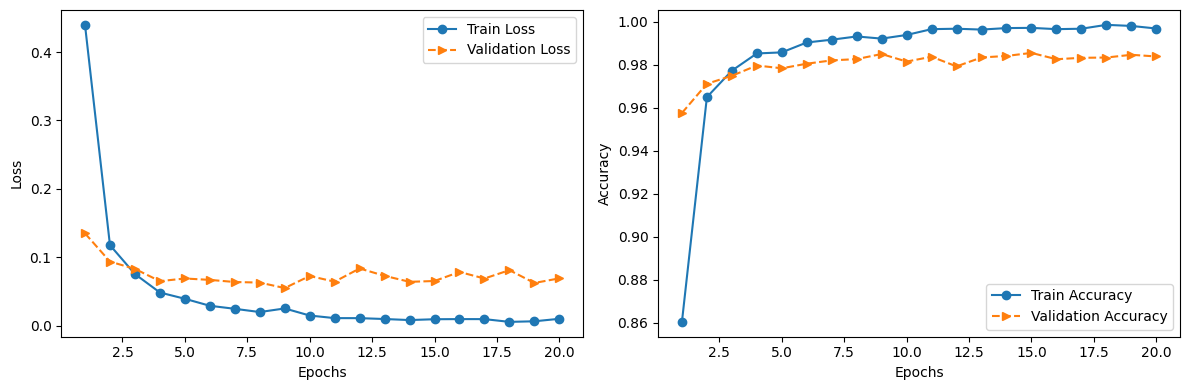

In [56]:
x_arr = np.arange(len(hist[0])) + 1
fig, axs = plt.subplots(1, 2, figsize= (12, 4))
axs[0].plot(x_arr, hist[0], '-o', label= 'Train Loss')
axs[0].plot(x_arr, hist[1], '-->', label= 'Validation Loss')
axs[0].set_xlabel('Epochs', size= 10)
axs[0].set_ylabel('Loss', size= 10)
axs[0].legend(loc='upper right', fontsize= 10)

axs[1].plot(x_arr, hist[2], '-o', label= 'Train Accuracy')
axs[1].plot(x_arr, hist[3], '-->', label= 'Validation Accuracy')
axs[1].set_xlabel('Epochs', size= 10)
axs[1].set_ylabel('Accuracy', size= 10)
axs[1].legend(loc= 'lower right', fontsize= 10)

plt.tight_layout()
plt.show()

In [57]:
pred = model(mnist_test.data.unsqueeze(1) / 255.)
is_correct = (
    torch.argmax(pred, dim= 1) == mnist_test.targets
).float()
test_acc = is_correct.mean()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9857


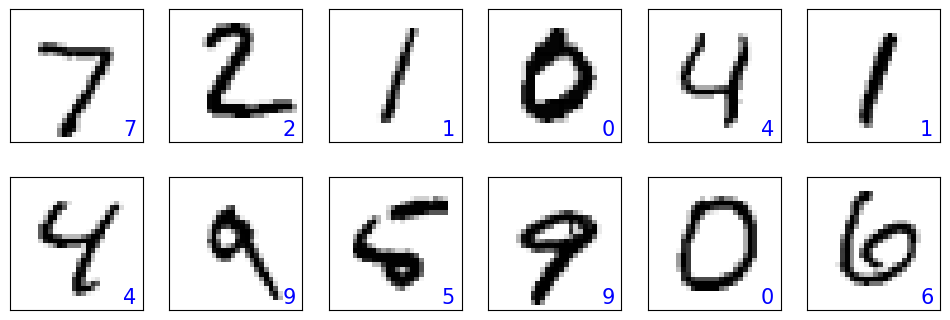

In [59]:
fig = plt.figure(figsize= (12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+ 1)
    ax.set_xticks([]), ax.set_yticks([]);
    img = mnist_test[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap= 'gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size= 15, color= 'blue',
            horizontalalignment= 'center',
            verticalalignment= 'center',
            transform= ax.transAxes)